# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [60]:
names = {'student_1': "Nihal Ezgi Yuceturk",
        'student_2': "Atakan Buyukoglu"}

sciper = {'student_1': 294689, 
          'student_2': 304491}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed = seed

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations = getRawDataFromFile()
r1, r2 = np.random.randint(0, len(conversations)-1 , 2)

In [3]:
print(conversations[r1], "\n\n")
print(conversations[r2])


['hi , i am a homemaker , how about you ?', 'i am an athlete . i run 2 miles daily for practice . i hate it .', 'oh i love a good run', 'well , i have done 3 triathlons and i would rather go snowboarding .', 'snowboarding sounds dangerous . that is the mom in me talking', 'that is what i tell my daughter too . she is an only child , you know .', 'i have two boys . any hobbies you are currently into ?', 'now that my daughter graduated college i would like us to travel .', 'nice . i am a neat freak who loved to cook', 'i certainly do not have those interest . you can always clean my house .', 'trust me . i probably would , i love neatness', 'what else do you like or want to do ?'] 


['i love its about to be fall !', 'yeah ? why do you love fall ?', 'i love green an i love playing tennis !', 'do you play tennis with your significant other ?', 'no with my dad he is a veteran .', 'my dad is an actor', 'i love to laugh at funny movies ! is he in any ?', 'yeah , but i do not watch them i hat

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** 
_Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. (Wikipedia)_ As seen from log-log plot, distribution of our word counts also follows the Zipf's Law. Zipf's Law is a kind of power law distributions where relative change in one variable results the proportional relative change in the other. Log-Log plots helps linearize this power-power relationship due to log function since exponentially related to variables are lineraly related with each other under logarithm function.


**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080 words appears only once in the entire dataset.



In [4]:
# Concatenate lits of list to single list
conlist = [y for x in conversations for y in x] 
# Join the list to a single string
seperator = " "
fullstring = seperator.join(conlist)
# Split each word
wordlist = fullstring.split()

In [5]:
wordlist = " ".join(conlist).split(' ')

In [6]:
# Count Frequency 
def form_dict(wordlist):
    word_dict = {}
    for w in wordlist:
        if(w not in word_dict):
            word_dict[w] = 1
        else :
            word_dict[w] +=1
    return word_dict
word_dict = form_dict(wordlist)

In [7]:
import operator
import collections
#import pandas
sorted_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse = True)

['i', '.', 'you', '?', ',', 'a', 'to', 'do', 'is', 'my', 'am', '!', 'the', 'that', 'have', 'are', 'and', 'like', 'it', 'not', 'in', 'what', 'of', 'for', 'how', 'love', 'but', 'good', 'me', 'just', 'so', 'with', 'work', 'your', 'on', 'too', 'at', 'be', 'about', 'no', 'oh', 'well', 'yes', 'would', 'great', 'hi', 'was', 'doing', 'cool', 'can', 'favorite', 'nice', 'from', 'there', 'they', 'time', 'go', 'really', 'all', 'get', 'as', 'any', 'today', 'will', 'its', 'fun', 'hello', 'we', 'sounds', 'out', 'an', 'very', 'one', 'music', 'up']
[103476, 101587, 48295, 43768, 39499, 34213, 32102, 30574, 28573, 26950, 24797, 23246, 21139, 20133, 18422, 17934, 16756, 16708, 14512, 14116, 13501, 13188, 12253, 11337, 10903, 10748, 8145, 8036, 7958, 7810, 7655, 7228, 6373, 6014, 5876, 5872, 5854, 5686, 5523, 5048, 4930, 4701, 4569, 4548, 4511, 4485, 4338, 4250, 4196, 4161, 4121, 4078, 4005, 3970, 3891, 3859, 3852, 3805, 3687, 3569, 3552, 3490, 3278, 3255, 3240, 3238, 3200, 3159, 3056, 3029, 2985, 2976, 2

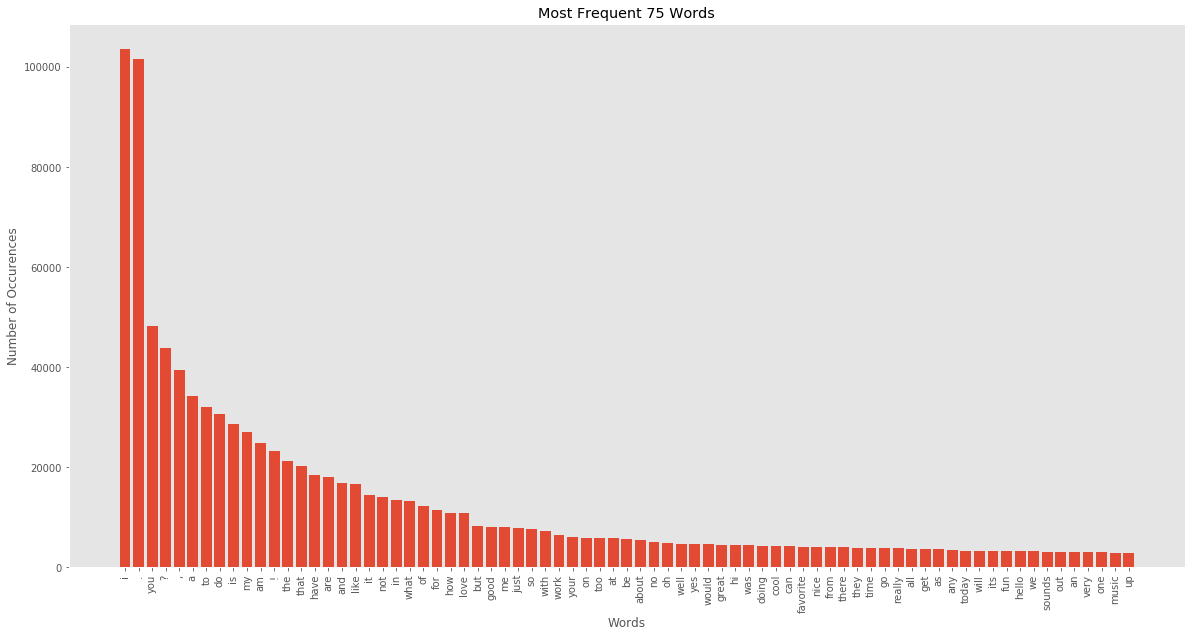

In [8]:
words = [x[0] for x in sorted_dict[:75]] 
freqs = [x[1] for x in sorted_dict[:75]]
print(words)
print(freqs)
fig = plt.figure(figsize=(20,10))
plt.bar( x = words,
         height = freqs)
plt.xticks(words, rotation=90)
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.title("Most Frequent 75 Words")
plt.show()

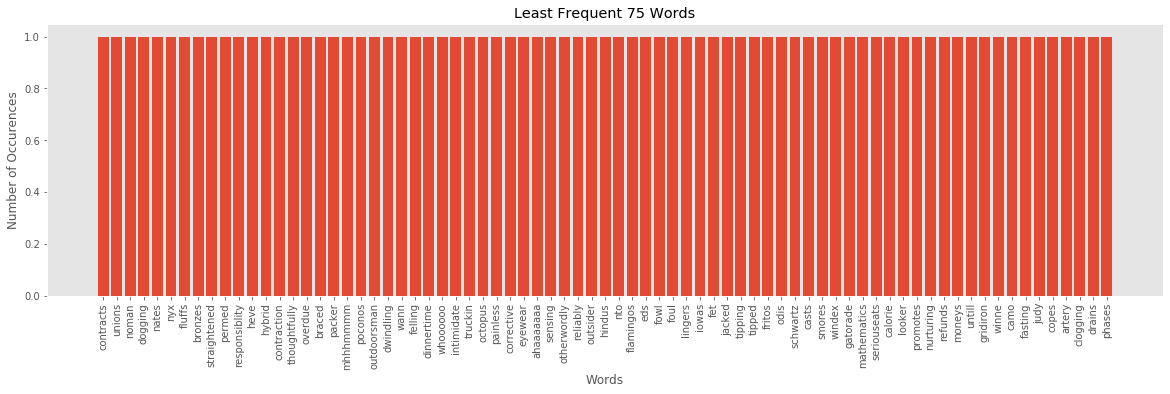

In [9]:
words = [x[0] for x in sorted_dict[-75:]] 
freqs = [x[1] for x in sorted_dict[-75:]]
fig = plt.figure(figsize=(20,5))
plt.bar( x =words,
         height = freqs)
plt.xticks(words, rotation=90)
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.title("Least Frequent 75 Words")
plt.show()

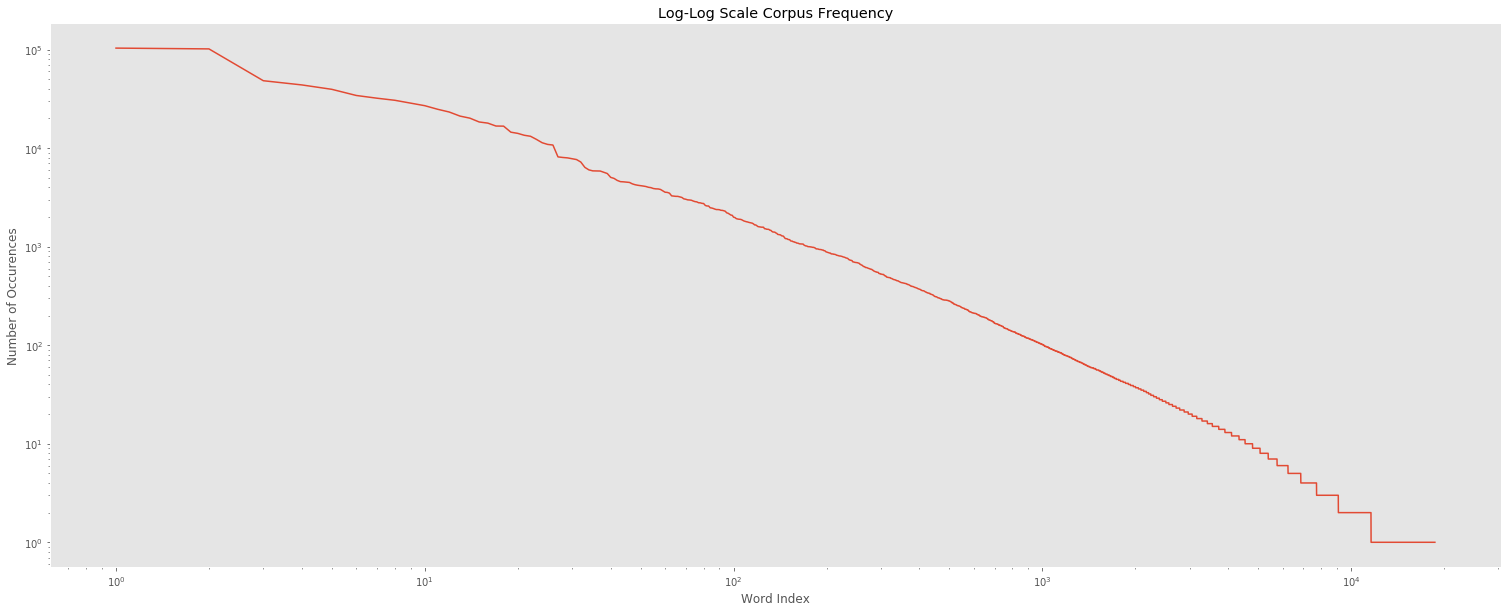

In [10]:
words_index = np.arange(1, len(sorted_dict)+1, 1)
freqs = [x[1] for x in sorted_dict ]
fig = plt.figure(figsize=(26,10))
plt.loglog( words_index,freqs)
plt.xlabel("Word Index")
plt.ylabel("Number of Occurences")
plt.title("Log-Log Scale Corpus Frequency")
plt.show()

In [11]:
freq_1 = freqs.count(1)
#sum(1 for value in word_dict.values() if value == 1) 
print("Number of words appeared only once in the entire dataset:", freq_1)

Number of words appeared only once in the entire dataset: 7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer TODOOOOOOOOOO**: The number of unique wprds decreased from 18673 to 6240 , which means a decrease of 12433 words due to rare event suppression.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer TODOOOOOOOOOOO**: When sentences with words with up to and including 5 appearances are excluded, the number of sentences in the filtered dataset decreased to 112264, from the original sentence count of 131424. This means that 19160 sentences are filtered.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: Rare words would cause the learning algorithm to try using those words at the expense of more frequent words; however, their usage in another conversation is very unlikely. Not all words are used in this dataset, and learning from the very rare words would mean learning the training dataset. But this would mean overfitting the training dataset, since the other very rare words are not learned. Hence, it is better to exclude rare words from the dataset to avoid overfitting.

In [12]:
freqs = np.asarray([x[1] for x in sorted_dict ])
words = np.asarray([x[0] for x in sorted_dict ])

In [13]:
sentencelist = [x.split(' ') for x in conlist]

In [14]:
least_freq_words = words[freqs<=5]
filteredlist = []
for sent in sentencelist:
    if not any ([w in sent for w in least_freq_words]):
#         print(val, least_freq_words[[w in sent for w in least_freq_words]], sent)
        filteredlist.append(sent)

In [15]:
sent = "'do you want to read to me ?', 'sure . exercise is so much fun !', 'do you want to read my blog', 'will you be my friend ? lots of people want to .', 'yes , i will be . i will read to you', 'they always want me to do their makeup too . is it makeup blog ?', 'it is just a reviews blog mostly .', 'green eggs and ham ? my smile is really nice .', 'no . i will review you .', 'i , however , am not . i am going to exercise now . ok !', 'that is not what i want though', 'ok . if you want you can read to me now .', 'okay , it is a scary story is that okay ?', 'yep . i love scary stories .' 'hi ! how are you ? i am married to miss usa .', 'wow very cool ! i am 30 .', 'nice ! i have so much money more then i know what to do with .', 'well you can donate it to the charity i work for that helps kids', 'that is nice you help kids ! mine are a disappointment .', 'i am sorry to hear that ! any favorite foods ? mine is cheese', 'my favorite dessert is strawberry cheesecake .', 'i can not eat shellfish , i am allergic', 'that is not good and messy . i have maids that could clean it up .', 'nice can i borrow one ? lol', 'yes ! i am getting bored of them !', 'lol any hobbies ? my is horseback riding', 'i love horses ! i love to craft too !', 'i also like to craft !', 'favorite things to make ? wreaths , shirts , glasses are what i mostly make .', 'i like to make wineglass candles .']"



any ([w in sent for w in least_freq_words ])

True

In [16]:
print('The number of sentence in the filtered dataset: ', len(filteredlist))
print('The number of sentence in the original dataset: ', len(conlist))
print('The Number of filtered sentences: ', len(conlist) - len(filteredlist))

The number of sentence in the filtered dataset:  112264
The number of sentence in the original dataset:  131424
The Number of filtered sentences:  19160


In [17]:
# Concatenate lits of list to single list
filtered_wordlist = [y for x in filteredlist for y in x]
filtered_dict = form_dict(filtered_wordlist)
filtered_dict = sorted(filtered_dict.items(), key=operator.itemgetter(1), reverse = True)

In [18]:
print('The number of unique words decreased from', len(word_dict), 'to', len(filtered_dict), ', which means a decrease of',
      len(word_dict) - len(filtered_dict), 'words due to rare event suppression.')

The number of unique words decreased from 18673 to 6240 , which means a decrease of 12433 words due to rare event suppression.


In [19]:
len(least_freq_words)

12431

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [20]:
filtered_words = ['PADD'] + ['START'] + ['END'] + [x[0] for x in filtered_dict ]
# Form the dictionary to convert words to ints
int_dict = {}
for idx, word in enumerate(filtered_words):
    int_dict[word] = idx

In [21]:
# Add START and END to each sentence
for idx, sent in enumerate(filteredlist):
    filteredlist[idx] = ['START'] + sent + ['END']

In [22]:
#Turn Strings to Integers
sentToInt = [[int_dict[x] for x in sent] for sent in filteredlist]

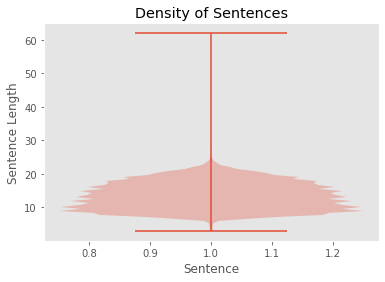

In [23]:
# The violin plot of the sentence lengths of the filtered list with tokenization
fig = plt.figure()
plt.violinplot(dataset = [len(x) for x in sentToInt])
plt.xlabel("Sentence")
plt.ylabel("Sentence Length")
plt.title("Density of Sentences")
plt.show()


In [24]:
tokenized_sent = pad_sequences(sentToInt, maxlen=25)

In [25]:
tokenized_sent[0]

array([   0,    0,    1,   44,    7,   25,   17,    5,   47,    6,    3,
         13,  214,  361,   10,    9,   83, 5132, 2862,   10,  248,   24,
        953,    4,    2], dtype=int32)

In [26]:
int_to_word = {b:a for a, b in int_dict.items()} 
# Generate random integers
r1, r2 = np.random.randint(0, len(tokenized_sent)-1 , 2)
sent1 = [x for x in tokenized_sent[r1] if (x >2)]
sent2 = [x for x in tokenized_sent[r2] if (x >2)]
sent1 = [ int_to_word[x] for x in sent1 ]
sent2 = [ int_to_word[x] for x in sent2 ]
print('First Random Sentence: ', sent1)
print('Second Random Sentence:', sent2)

First Random Sentence:  ['i', 'will', 'look', 'at', 'it', 'at', 'ny', 'new', 'job']
Second Random Sentence: ['pretty', 'good', ',', 'doing', 'as', 'much', 'as', 'a', 'i', 'can', 'for', 'being', 'in', 'a', 'wheel', 'chair']


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [27]:
import pickle
#save
with open("data.pkl", "wb") as file:
    pickle.dump([filteredlist, int_dict, tokenized_sent], file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

In [37]:
import pickle
#load
with open("data.pkl", "rb") as file:
    [filteredlist, int_dict, tokenized_sent] = pickle.load(file)

In [38]:
tokens = tokenized_sent
maxlen = len(tokens[0])

In [43]:
tokens[451]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,  87,   9,   5, 101, 293,   2],
      dtype=int32)

In [47]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [79]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [81]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = SimpleRNN(hidden_size, activation='tanh')(E['RNN']) #... Recurrent layer(s)

#R['RNN'] = H['RNN']#... Readout
Y['RNN'] = Dense(maxlen-1, activation='softmax')(H['RNN'])#... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           14369792  
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dense_23 (Dense)             (None, 24)                1560      
Total params: 14,383,704
Trainable params: 14,383,704
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = tokens
T = tokens


print(X[:,:-1].shape, T[:,1:].shape)

#logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
logs['RNN'] = models['RNN'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
# with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
#     pickle.dump(logs['RNN'], file)
# models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

(112264, 24) (112264, 24)
Train on 89810 samples, validate on 22453 samples
Epoch 1/32
89810/89810 [==============================] - 402s 4ms/step - loss: 5339.5573 - acc: 0.7412 - val_loss: 4633.3927 - val_acc: 0.8388
Epoch 2/32
89810/89810 [==============================] - 381s 4ms/step - loss: 4535.2233 - acc: 0.8850 - val_loss: 4513.5854 - val_acc: 0.8880
Epoch 3/32
89810/89810 [==============================] - 382s 4ms/step - loss: 4483.1479 - acc: 0.9013 - val_loss: 4504.8592 - val_acc: 0.8907
Epoch 4/32
89810/89810 [==============================] - 384s 4ms/step - loss: 4461.0254 - acc: 0.9116 - val_loss: 4494.7074 - val_acc: 0.8849
Epoch 5/32
89810/89810 [==============================] - 384s 4ms/step - loss: 4448.5364 - acc: 0.9175 - val_loss: 4456.7817 - val_acc: 0.9123
Epoch 6/32
89810/89810 [==============================] - 385s 4ms/step - loss: 4442.1386 - acc: 0.9200 - val_loss: 4455.5020 - val_acc: 0.9173
Epoch 7/32
89810/89810 [==============================] - 38

In [ ]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [ ]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()
